# MATH 60210 - H2022

Nasim Siami

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

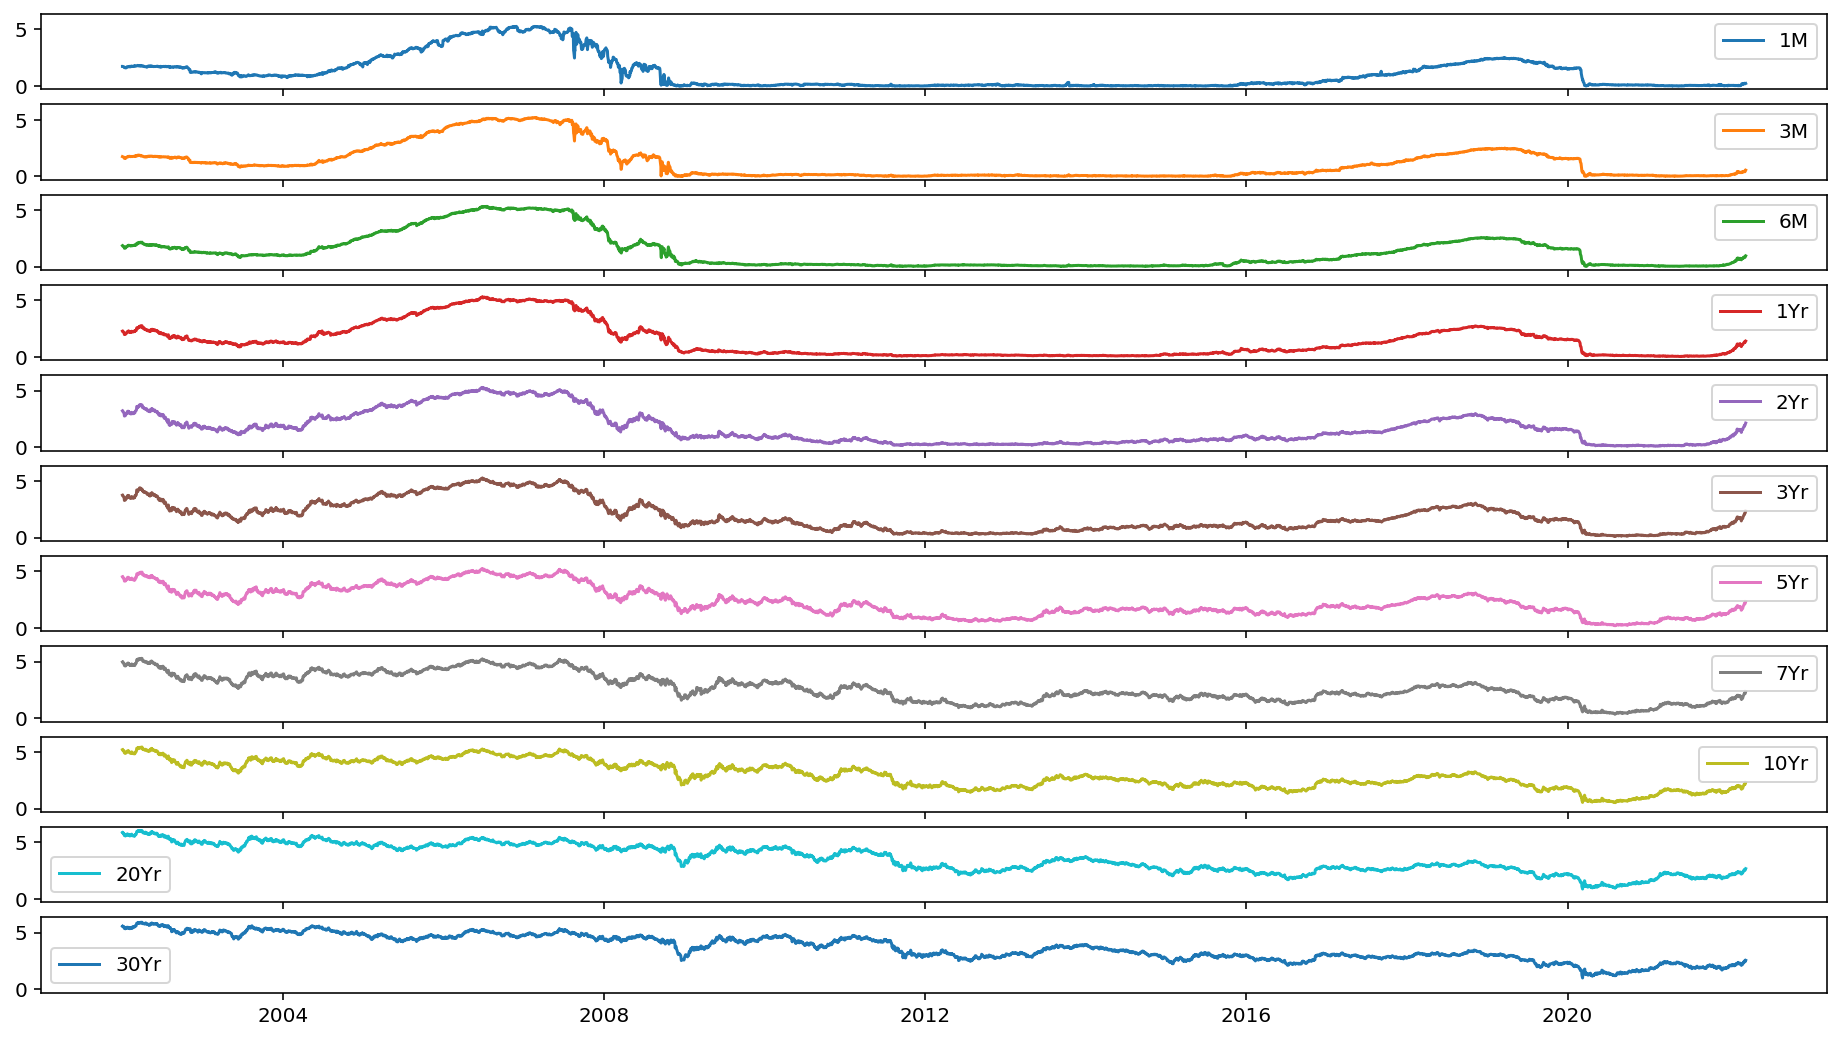

In [1]:
import numpy as np
import numpy.random as npr
import pandas as pd
import statsmodels.api as sm
import datetime as dt

# the following configures pandas_datareader and its cache.
import os
import pandas_datareader as pdr
import requests_cache

expire_after = dt.timedelta(days=3)
session = requests_cache.CachedSession(
    cache_name=os.path.expanduser('~/.cache/requests_cache'),
    backend='sqlite',
    expire_after=expire_after)

FRB_H15 = pd.read_excel('FRB_H15.xlsx',
                        header=None,
                        names=[
                            '1M', '3M', '6M', '1Yr', '2Yr', '3Yr', '5Yr',
                            '7Yr', '10Yr', '20Yr', '30Yr'
                        ],
                        skiprows=7,
                        parse_dates=True,
                        na_values='ND').dropna(axis=0)
FRB_H15.plot(subplots=True, sharey=True, sharex=False, figsize=(16, 9))

## Question 1

### Part a

Write a function that accepts a list containing series names and returns a dataframe containing the those series.

- It reads all the series from [FRED](https://fred.stlouisfed.org/) (the **F**ederal **R**eserve **E**conomic **D**atabase).
- The argument `dropna` controls whether or not rows containing missing values should be dropped.
- The argument `plot` controls whether or not the retrieved series are graphed.
- Please use the cache when coding with `pandas_datareader`. (It's polite *and* makes your code run faster!)

In [2]:
def GetFRED(SeriesList, start, end, dropNA=True, plot=True):
    """
    Retrieves data series from FRED
    Arguments:
        SeriesList     [Python list] names of series to retrieve
        start,end      [datetime format dates] range of series to retrieve
        dropna         [Boolean] if True, rows with missing values will be dropped
        plot           [Boolean] if True, all series will be plotted (1 series per panel)
    """
    ### BEGIN SOLUTION
    FREDdata = pdr.DataReader(SeriesList, 'fred', start, end, session=session)
    if dropNA:
        FREDdata.dropna(axis=0, inplace=True)
    if plot:
        FREDdata.plot(subplots=True,
                      sharey=True,
                      sharex=False,
                      figsize=(16, 9))
    return FREDdata
    ### END SOLUTION

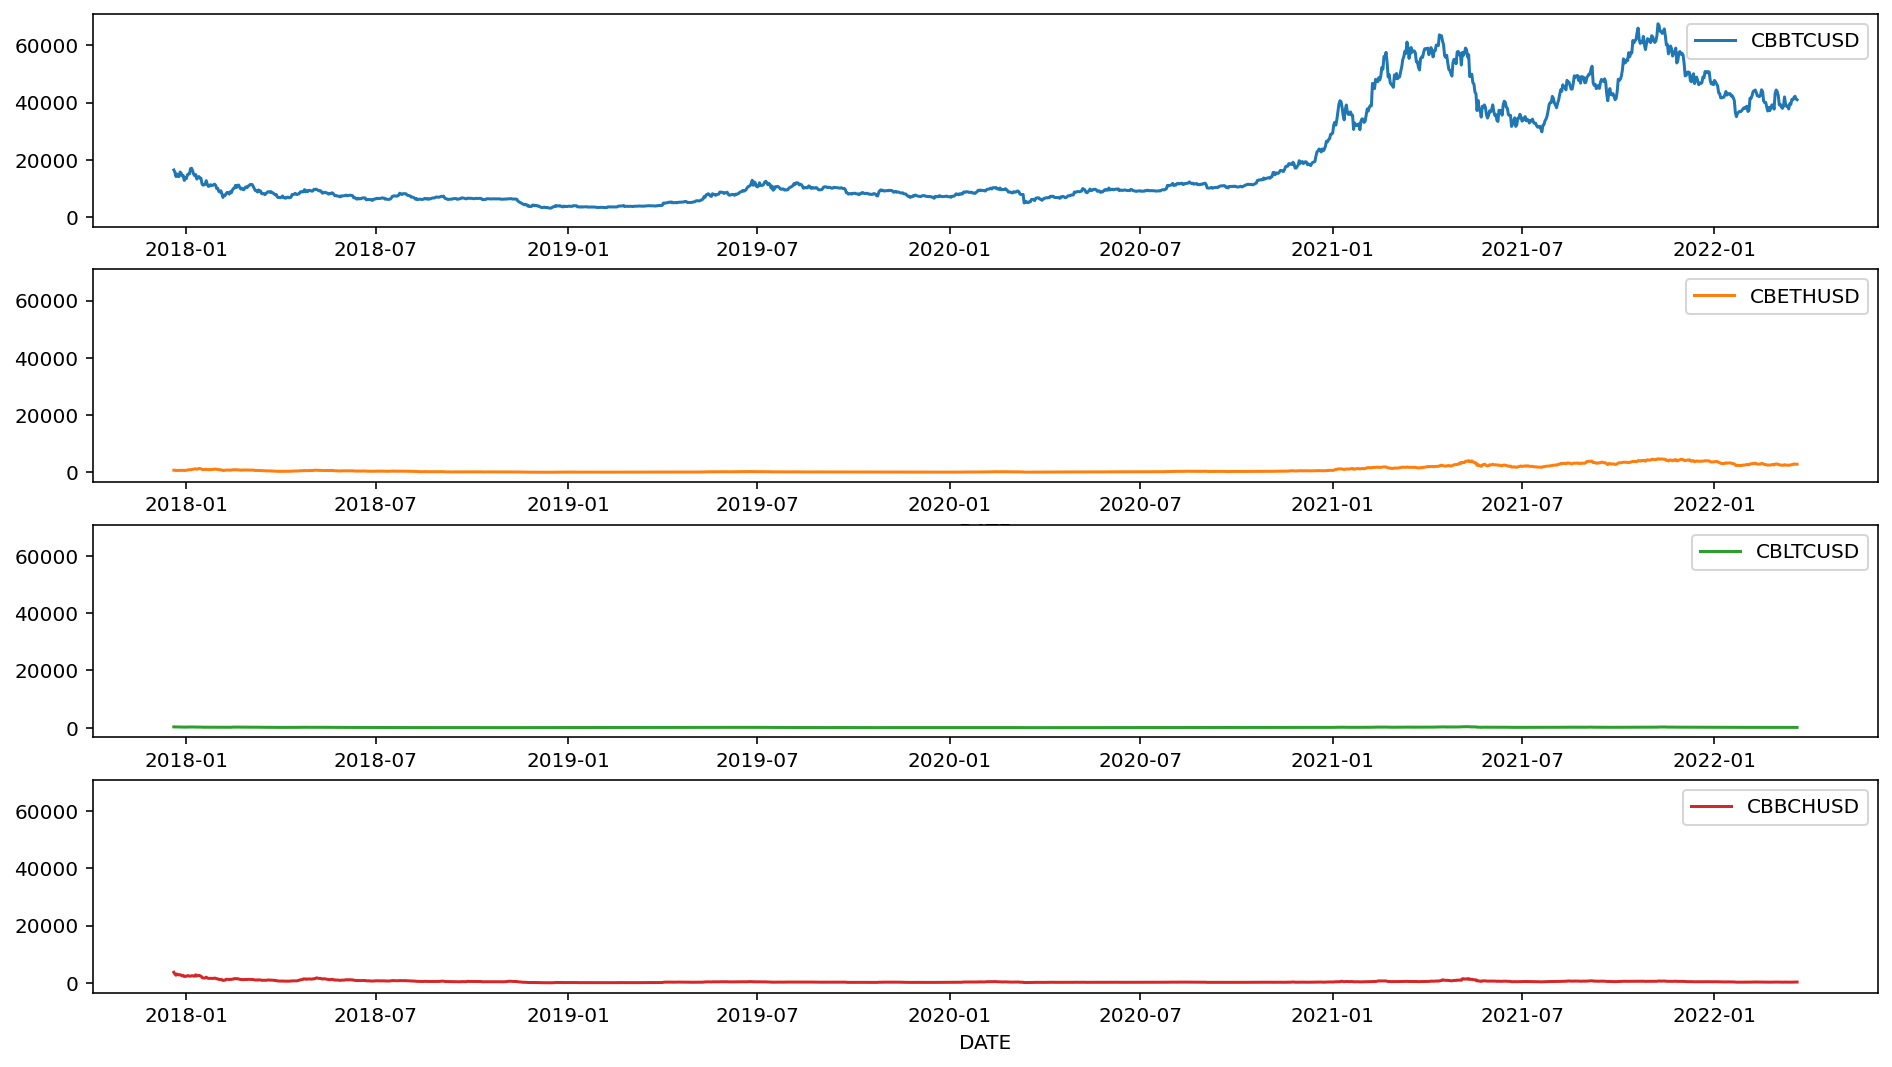

In [3]:
# retrieve all USD Coinbase prices for BitCoin, Etherium Litecoin and BitcoinCash, then drop NA's.
coinbase = GetFRED(['CBBTCUSD', 'CBETHUSD', 'CBLTCUSD', 'CBBCHUSD'],
                   dt.datetime(2014, 12, 1),
                   dt.datetime(2022, 3, 21),
                   dropNA=False,
                   plot=False)
assert np.isnan(coinbase['CBLTCUSD']['2015-12-07'])
coinbase = GetFRED(['CBBTCUSD', 'CBETHUSD', 'CBLTCUSD', 'CBBCHUSD'],
                   dt.datetime(2014, 12, 1), dt.datetime(2022, 3, 21))
assert coinbase['CBBTCUSD']['2022-03-17'] == 40964.07



### Part b

Write a function that accepts a DataFrame, and for each series it contains

- the function runs the Phillips-Perron and the KPSS tests (from the ARCH package)
- returns a DataFrame with three columns giving
  - the p-value of the Phillips-Perron test (the 'tau' test statistic)
  - the p-value of the KPSS test
  - the order of integration of the series (0 or 1 or 'NA' if the tests do not agree)
  and one row for each series.

The number of lags for both tests should be the default values from the ARCH package.<br>
Use a 5% significance level to judge whether series are I(0) or I(1).

Include an option that controls whether or not $H_A$ includes trend-stationarity.



In [4]:
from arch.unitroot import PhillipsPerron, KPSS


def I0or1(df, HAtrend=False):
    """
    Determines whether series are I(0) or I(1)
    Arguments:
        df     [DataFrame] series (in columns) to test
        trend  [Boolean] allow for trend-stationarity under H_A?
    Returns:
        out    [DataFrame] index is the column names of df
               columns are ['PP', 'KPSS', 'I()'] 
               The first two columns contain floats, while the last column contain an integer (or NAN)
    """
    ### BEGIN SOLUTION
    out = pd.DataFrame(index=df.columns, columns=['PP', 'KPSS', 'I()'])
    if HAtrend:
        for column in df:
            out['PP'][column] = PhillipsPerron(df[column], trend='ct').pvalue
            out['KPSS'][column] = KPSS(df[column], trend='ct').pvalue
    else:
        for column in df:
            out['PP'][column] = PhillipsPerron(df[column]).pvalue
            out['KPSS'][column] = KPSS(df[column]).pvalue
    for column in df:
        if out['PP'][column] < 0.05 and out['KPSS'][column] > 0.05:
            out['I()'][column] = 0
        elif out['PP'][column] > 0.05 and out['KPSS'][column] < 0.05:
            out['I()'][column] = 1
    return out
    ### END SOLUTION

In [5]:
test0 = I0or1(coinbase)
test1 = I0or1(coinbase, HAtrend=True)

assert test0['I()']['CBBTCUSD'] == 1 and np.isnan(test0['I()']['CBLTCUSD'])
assert test0['KPSS']['CBETHUSD'] == 0.0001 and np.isclose(
    test1['PP']['CBBCHUSD'], 0.0)
assert np.isclose(test1['PP']['CBLTCUSD'], 0.018883) and np.isclose(
    test0['PP']['CBBTCUSD'], 0.805451)


### Part c

Let's assume that the log of the prices of Bitcoin (__CBBTCUSD__) and that of Etherium (__CBETHUSD__) are both $I(1)$.<br>
Test the $H_0$ that they are not cointegrated using `engle_granger()`.

- Allow for a constant (but no trend) in the cointegrating relationship.
- Select the number of lags using the BIC

Is the price of Bitcoin cointegrated with that of Etherium?



In [6]:
from arch.unitroot import engle_granger

# We'll just work with the data in the df coinbase.
EGresults = engle_granger(coinbase['CBBTCUSD'],
                          coinbase['CBETHUSD'],
                          trend='c',
                          method='bic')
# We don't *really* need to specify `trend` or `method` since these are just the default values.
EGresults.summary()

Test Statistic,-2.143
P-value,0.452
ADF Lag length,0
Estimated Root ρ (γ+1),0.994


In [7]:
# What if we did the regression the other way around?
engle_granger(coinbase['CBETHUSD'], coinbase['CBBTCUSD']).summary()

Test Statistic,-2.126
P-value,0.460
ADF Lag length,0
Estimated Root ρ (γ+1),0.994


_Write here, briefly explaining your conclusion._
_Be sure to mention:_

- _the test statistic that you got_
- _its p-value or its critical value under $H_0$_
- _your conclusion_
- _your estimate of the cointegrating vector (only if you conclude that the series are cointegrated.)_

---

I got a test statistic of **\-2.143** and a p\-value of only **0.452**, so I conclude that there is no evidence of cointegration.  


- The results are pretty insensitive to the way that we run the regression.



## Question 2

### Part a

Write a function that accepts a DataFrame containing several series and 

- Calculates all their principal components using the _covariance_ matrix of the data
- returns the weights of each data series in the 1st principal component.
- returns the number of principal components required to account for 50%, 90% and 99% of the overall variance in the data series.
- (optionally) plots the principal components
- (optionally) provides a scree plot



In [8]:
from statsmodels.multivariate.pca import PCA


def MyPCA(df, VCV=True, PCplot=False, Screeplot=False):
    """
    A function to perform PCA analysis. 
    Arguments:
        df     [DataFrame] containing data series to analyse
        VCV    [Boolean] use Covariance if True, Correlation matrix if False.
        PCplot [Boolean] controls graphing of PCs
        Screeplot     [Boolean] controls graphing of Scree plot
    Returns:
        w      [1-D array] containing weights of each data series in 1st PC
        Decomp [1-D array] integer values of 1 of PCs to account for '50', '90',  and '99'% of overall variance
    """
    ### BEGIN SOLUTION
    # Put correct code here.  This code is removed for the student version, but is used
    # to confirm that your tests are valid.
    if VCV:
        PCres = PCA(df, standardize=False)
    else:
        PCres = PCA(df)
    if PCplot:
        PCres.factors.plot()
    if Screeplot:
        PCres.plot_scree()
    w = PCres.loadings.iloc[:, 0]  # weights for the 1st PC
    Decomp = np.ones(3, dtype=np.int8)
    Decomp[0] = np.sum(PCres.rsquare <= 0.50)
    Decomp[1] = np.sum(PCres.rsquare <= 0.90)
    Decomp[2] = np.sum(PCres.rsquare <= 0.99)
    ### END SOLUTION
    return w, Decomp

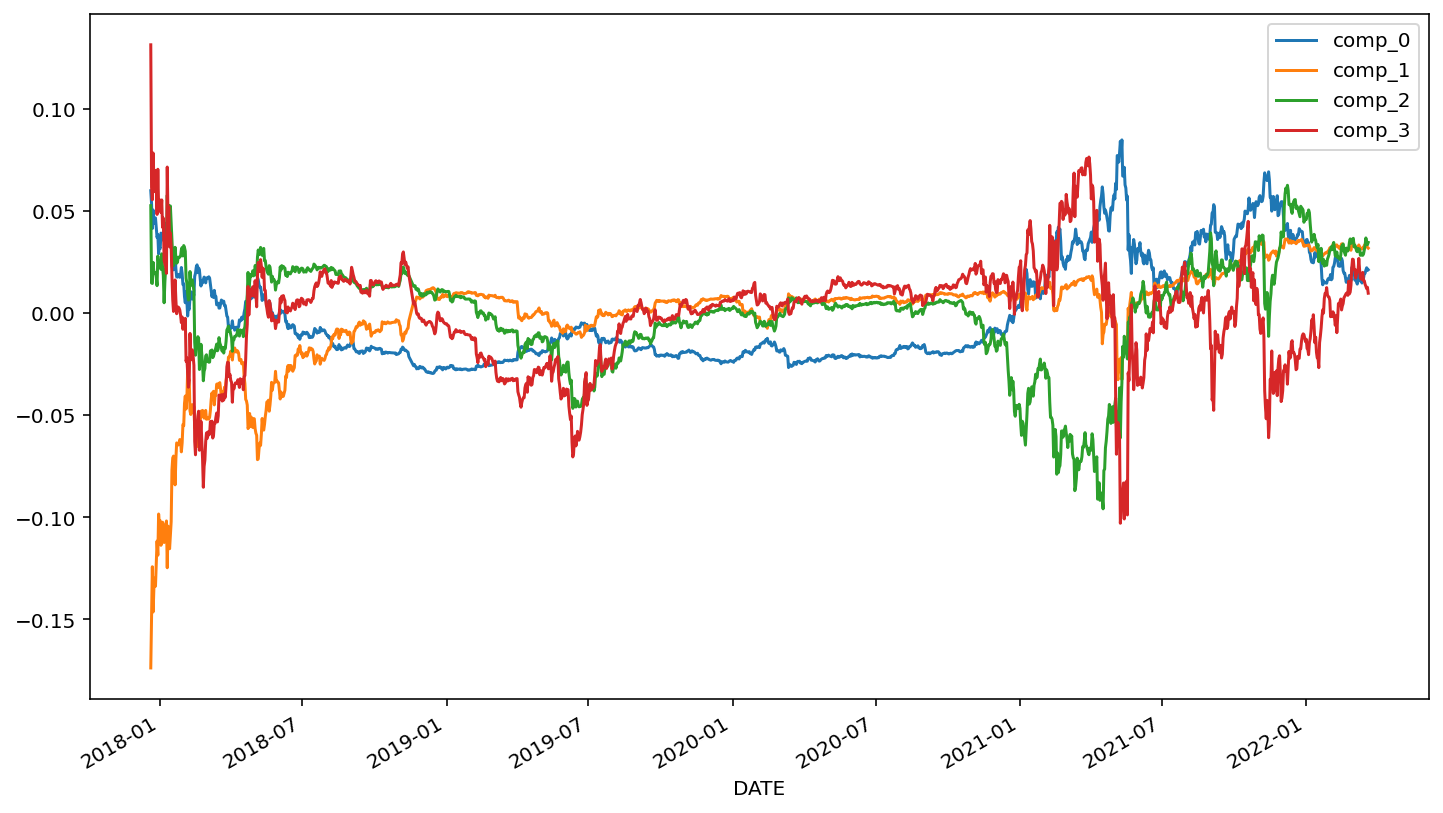

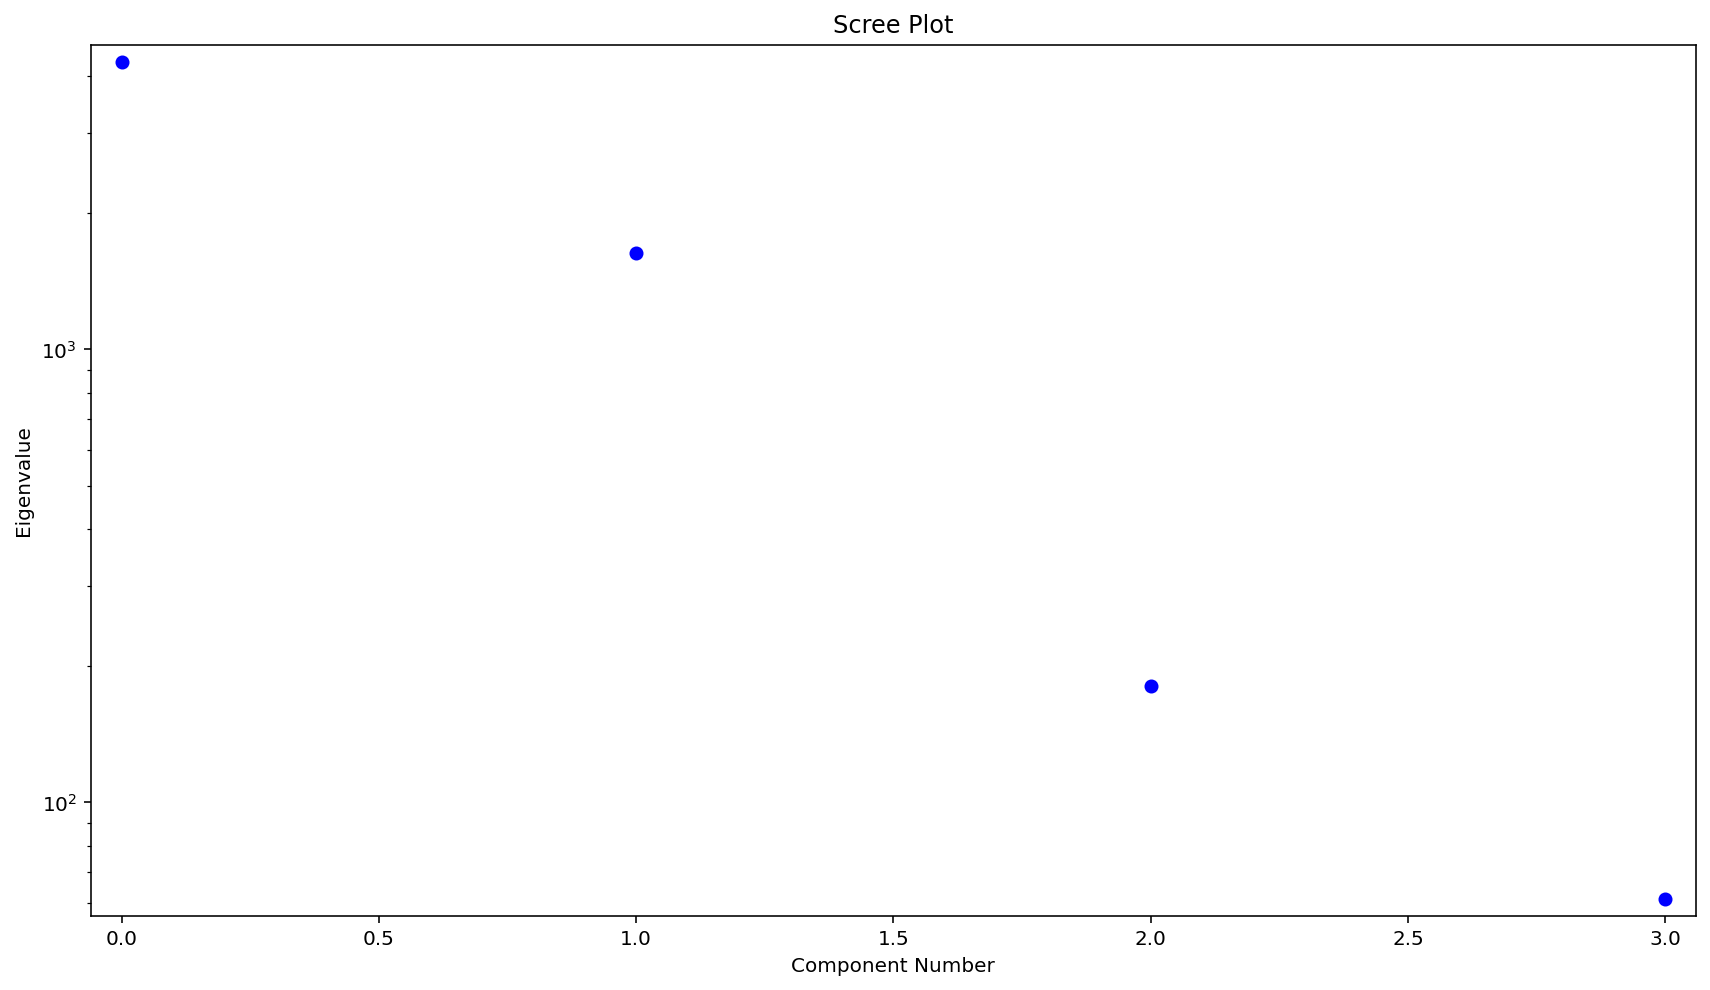

In [9]:
CB_w, CB_D = MyPCA(coinbase)
assert np.allclose(CB_w, [0.997946, 0.063917, 0.002705, 0.003323], atol=1e-5)
assert np.all(CB_D == [1, 1, 1])

CB_w, CB_D = MyPCA(coinbase, VCV=False, PCplot=True, Screeplot=True)
assert np.allclose(CB_w, [0.536737, 0.540477, 0.562170, 0.322123], atol=1e-5)
assert np.all(CB_D == [1, 2, 3])

# Now some hidden tests with random values....
### BEGIN HIDDEN TESTS
# students will NOT see these extra tests
anniversary = 20040410
np.random.seed(anniversary)
CB_w, CB_D = MyPCA(pd.DataFrame(np.random.randn(200, 8)))
assert np.all(CB_D == [4, 7, 8])
assert np.allclose(CB_w, [
    -0.420687, 0.258564, -0.208179, -0.747770, 0.123178, 0.265721, 0.237486,
    -0.107187
],
                   atol=2e-4)
### END HIDDEN TESTS

### Part b

FRB_H15 is a dataframe containing daily yields on US Treasury debt of various maturities from the beginning of 2002 to mid-March 2022. Calculate its PC's and show the weights that the first PC puts on each maturity.

What kind of yield curve factor does it capture?



In [10]:
# Here's a look at the contents of the DataFrame
FRB_H15

,1M,3M,6M,1Yr,2Yr,3Yr,5Yr,7Yr,10Yr,20Yr,30Yr
2002-01-02,1.73,1.74,1.85,2.28,3.22,3.75,4.52,4.97,5.20,5.86,5.56
2002-01-03,1.73,1.73,1.82,2.24,3.19,3.71,4.48,4.93,5.16,5.83,5.54
2002-01-04,1.72,1.72,1.82,2.25,3.19,3.72,4.50,4.97,5.18,5.87,5.57
2002-01-07,1.70,1.68,1.77,2.19,3.08,3.61,4.39,4.86,5.09,5.76,5.49
2002-01-08,1.70,1.68,1.77,2.19,3.07,3.60,4.39,4.86,5.10,5.77,5.51
...,...,...,...,...,...,...,...,...,...,...,...
2022-03-15,0.22,0.46,0.86,1.28,1.85,2.04,2.10,2.16,2.15,2.57,2.49
2022-03-16,0.24,0.44,0.86,1.35,1.95,2.14,2.18,2.22,2.19,2.56,2.46
2022-03-17,0.20,0.40,0.81,1.30,1.94,2.14,2.17,2.22,2.20,2.60,2.50
2022-03-18,0.19,0.42,0.83,1.29,1.97,2.15,2.14,2.17,2.14,2.53,2.42


In [11]:
# Show your code and the weights here.

MyW, MyDecomp = MyPCA(FRB_H15)
MyW

1M     -0.329482
3M     -0.337581
6M     -0.348095
1Yr    -0.346258
2Yr    -0.336322
3Yr    -0.324602
5Yr    -0.298396
7Yr    -0.272496
10Yr   -0.250344
20Yr   -0.228795
30Yr   -0.199057
Name: comp_00, dtype: float64

_Write your explanation here._
_(Be Brief.)_

This will roughly capture the level of the yield curve.

- the negative signs are irrelevant because the sign is arbitrary
- the weights all fall within a range of ±30% of the mean weight

That said, there is somewhat less weight on maturities > 3Yrs.



## Question 3

### Part a

Write a function that accepts a DataFrame (like `FRB_H15`, above) and a series of maturities, and uses them to estimate the 3 Diebold-Li factors of the term structure.

- use the same value of $\lambda$ as Diebold and Li.

**Important Note:** To ensure that you understand what the factors are and how they are estimated, you really need to work this out yourself without relying on someone else's pre-built code.

- For this question, you may not submit *any* code from other sources that show how to calculate the Diebold-Li factors (even if you cite your source appropriately.)



In [12]:
def DieboldLi(df, tau):
    """
    Computes the Diebold-Li factors of the term structure.
    Arguments:
        df         [T x N DataFrame] yields at various maturities
        tau        [N x 1 pandas series]  maturities (in months) for each series in df
    Returns:
        DLfactors  [T x 3 DataFrame] Level, Slope and Curvature factors
    """
    ### BEGIN SOLUTION

    lamb = 0.0609  # Same as in Diebold and Li
    # Now transform the tau series to create factor loadings
    beta2 = (1 - np.exp(-lamb * tau)) / (lamb * tau)
    beta3 = beta2 - np.exp(-lamb * tau)
    # Let's put that into a DataFrame so that we can do some OLS regressions
    X_DL = pd.DataFrame({'Level': 1, 'Slope': beta2, 'Curvature': beta3})
    DLfactors = pd.DataFrame(index=df.index,
                             columns=['Level', 'Slope', 'Curvature'],
                             dtype='float64')
    for j in range(len(df.index)):
        model = sm.OLS(df.iloc[j].values, X_DL)
        DLfactors.iloc[j] = model.fit().params.values
    # We did roughly 5,000 OLS regressions in just under 4 seconds....
    return DLfactors

    ### END SOLUTION

In [13]:
# Of course, you remembered that the maturities are in *months*, right?
tau_H15 = pd.Series([1, 3, 6, 12, 24, 36, 60, 84, 120, 240, 360])
H15_factors = DieboldLi(FRB_H15, tau_H15)
assert np.allclose(H15_factors.head(1), [6.100714, -4.619723, -1.709717],
                   atol=1e-5)
assert np.allclose(H15_factors.tail(1), [2.463904, -2.318570, 2.563022],
                   atol=1e-5)
# How about just after the Lehman Brothers crash in 2008?
assert np.allclose(H15_factors.loc['2008-10-30'],
                   [4.865022, -4.482518, -3.055965],
                   atol=1e-5)
# and during the first wave of COVID-19?
assert np.allclose(H15_factors.loc['2020-03-16'],
                   [1.257899, -0.922809, -1.695948],
                   atol=1e-5)



### Part b

In a graph, show how the three Diebold-Li factors have varied during the pandemic (from the start of 2020 to the most recent data.)

Explain

- which factor(s) accounted for most of the movement in interest rates when the pandemic first reached the US in March 2020?
- which factor(s) accounted for most of the movement in interest rates over the past six months?



<AxesSubplot:title={'center':'Diebold-Li Factors for US Treasury Yields'}>

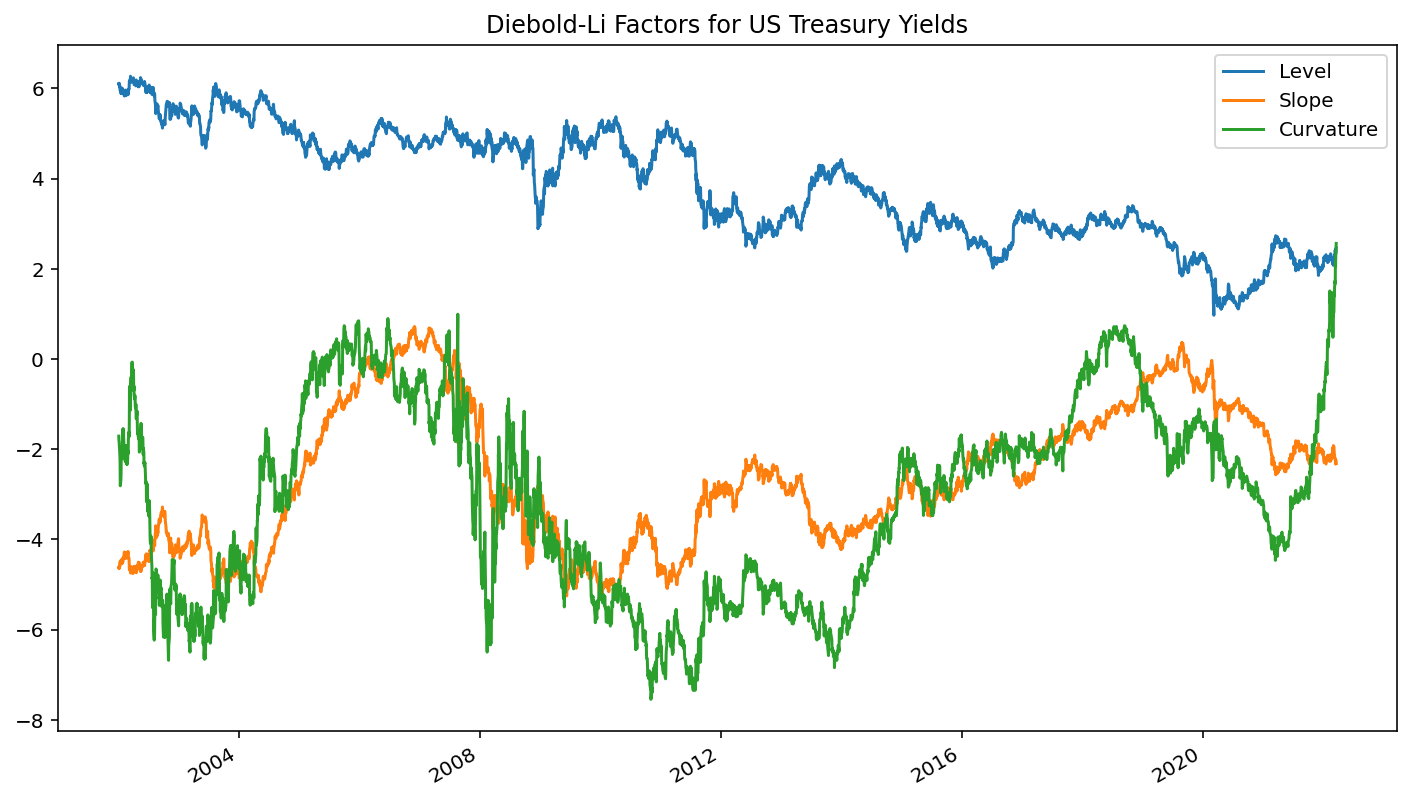

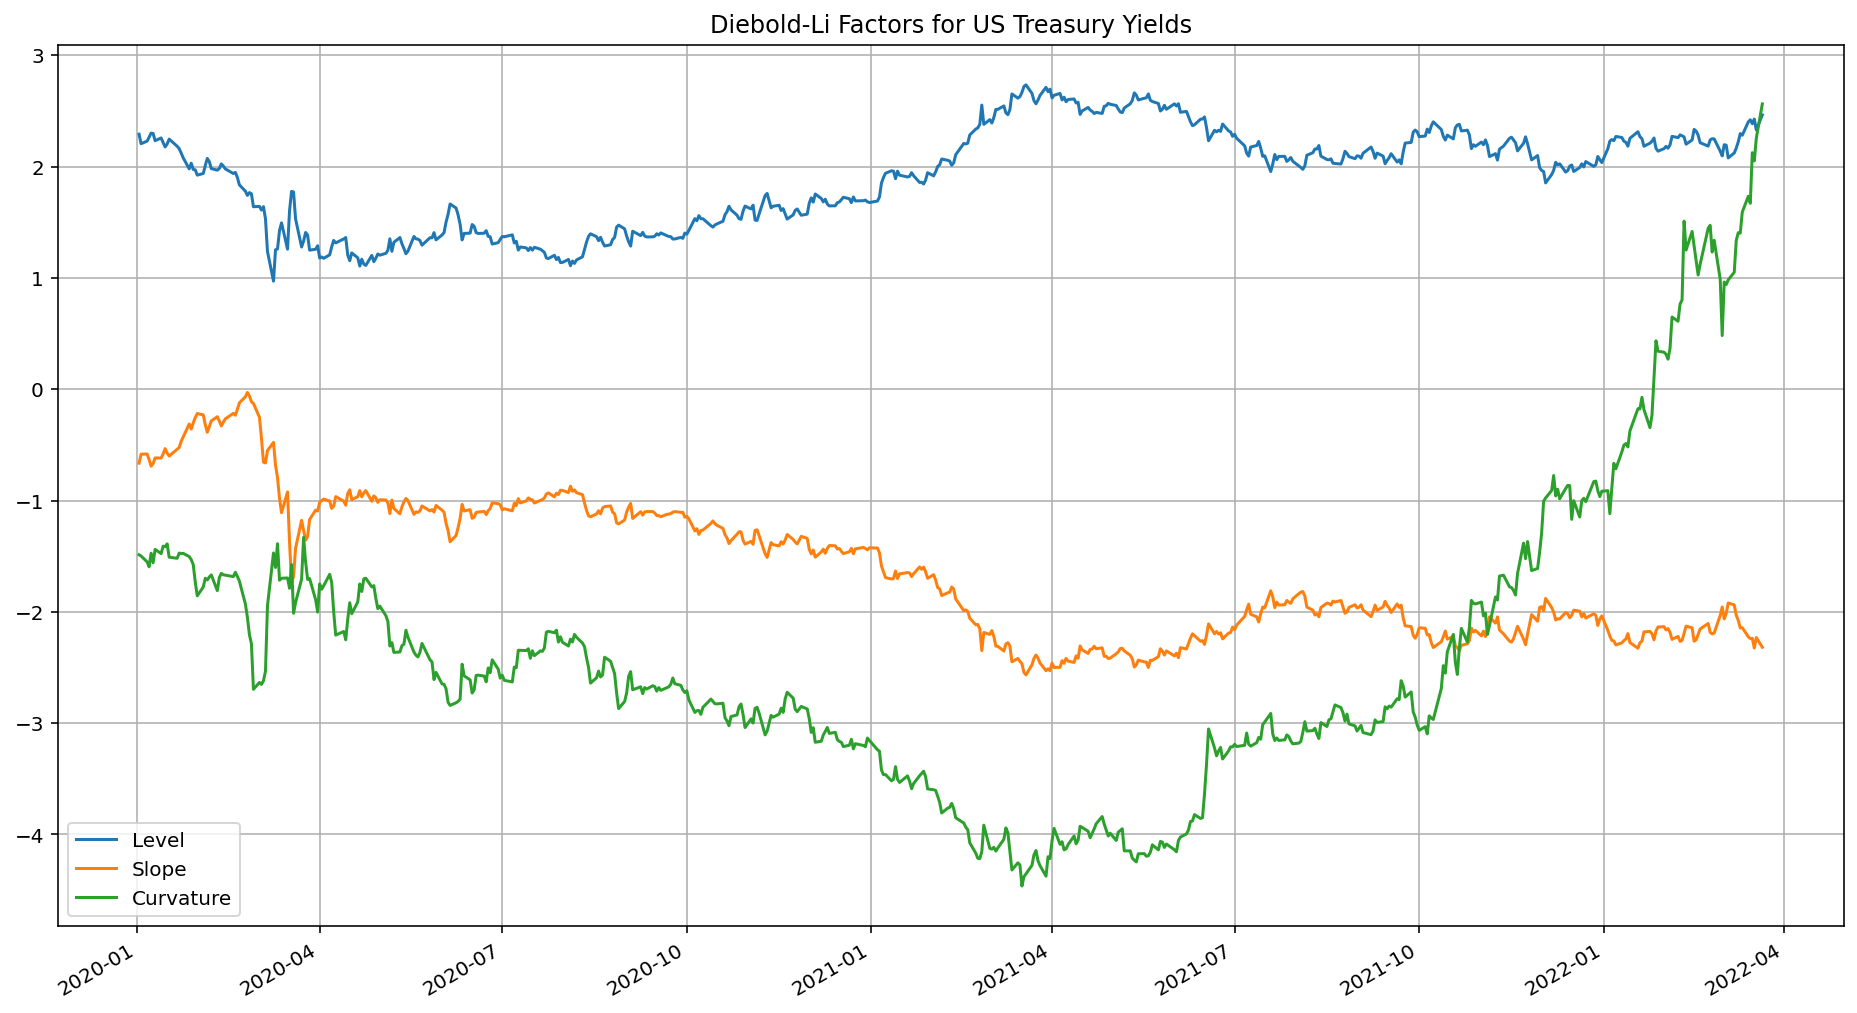

In [14]:
# put the code for your graph here
H15_factors.plot(title='Diebold-Li Factors for US Treasury Yields')

# Let's just focus on the pandemic
H15_factors['2020':].plot(title='Diebold-Li Factors for US Treasury Yields',
                          figsize=(16, 9),
                          grid=True)

_Write your explanations here_

In March 2020, we initially saw a short-lived ~100bp drop in the curvature factor, quickly replaced by a ~200bp fall in the slope and volatility in the level.

The last 6 months have been dominated by >500bp rise in curvature. 

